# Ture's Sendy Notebook
import:

In [1]:
import warnings
from datetime import datetime
from math import sqrt
from scipy.stats import zscore
import pandas as pd
import numpy as np
import seaborn as sns
import mplleaflet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.feature_selection import RFECV
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from hdbscan import HDBSCAN, approximate_predict
from sklearn.decomposition import PCA

from pprint import pprint

from IPython.core.interactiveshell import InteractiveShell
from tures_pipeline import *

InteractiveShell.ast_node_interactivity = "all" # enables multiple cell output
%matplotlib inline
pd.set_option('display.max_rows', 100)
warnings.simplefilter(action='ignore', category=FutureWarning)

load the prepared data:

In [2]:
tra = pd.read_pickle('data/prepped/Train.pkl')
te = pd.read_pickle('data/prepped/Test.pkl')  
ors = pd.read_pickle('data/prepped/ors_features.pkl')
uber = pd.read_pickle('data/prepped/uber_features.pkl')
trai = pd.merge(tra, ors, how='left', suffixes=('', '_o'), on=['PickupLong', 'PickupLat', 'DestinationLong', 'DestinationLat'])
tes = pd.merge(te, ors, how='left', suffixes=('', '_o'), on=['PickupLong', 'PickupLat', 'DestinationLong', 'DestinationLat'])
train = pd.merge(trai, uber, how='left', suffixes=('', '_u'), on=['PickupLong', 'PickupLat', 'DestinationLong', 'DestinationLat'])
test = pd.merge(tes, uber, how='left', suffixes=('', '_u'), on=['PickupLong', 'PickupLat', 'DestinationLong', 'DestinationLat'])
#Remove columns from train that are missing in test:
train.drop(columns=['ArrivalDestinationDom', 'ArrivalDestinationTime', 'ArrivalDestinationWd'], inplace=True)
train.shape
test.shape

(169756, 83)

(55679, 82)

cleaning:

In [3]:
train = train[train.TravelTime > 10]
train.Precipitation.fillna(0, inplace=True)
test.Precipitation.fillna(0, inplace=True)

feature engineering:

In [4]:
train['PrepTime'] = train.PickupTime - train.ArrivalPickupTime
test['PrepTime'] = test.PickupTime - test.ArrivalPickupTime
train['ors_speed'] = train.ors_distance / train.ors_duration * 3600
test['ors_speed'] = test.ors_distance / test.ors_duration * 3600
train['PickupH'] = train.PickupTime.values // 3600
test['PickupH'] = test.PickupTime.values // 3600

#train['mean_dist'] = (train.md + train.Distance) / 2
#test['mean_dist'] = (test.md + test.Distance) / 2

#mid-time

In [5]:
# PCA for temporal features
#temporal = ['PickupDom', 'PickupTime', 'PickupWd']
#pca2 = PCA(n_components=3)
#pca2.fit(train[temporal])
#plt.bar(range(pca2.n_components_), pca2.explained_variance_ratio_);
#plt.plot(np.cumsum(pca2.explained_variance_ratio_));
#train['pca21'], train['pca22'] = pca2.transform(train[temporal]).T
#test['pca21'], test['pca22'] = pca2.transform(test[temporal]).T

labelling:

In [22]:
label = 'TravelTime'

skipcols = ['ConfirmationDom', 'ArrivalDestinationWd', 'ArrivalDestinationDom', 
    'ArrivalPickupDom', 'ConfirmationWd', 'ArrivalPickupWd', 'PlacementDom', 'u0', 'dx', 
    'DestinationLong', 'PickupLong', 'PickupLat', 'DestinationLat', 'dy', 'v0', 
    'PlacementWd']
skipcols += ['ArrivalDestinationTime']
skipcols += [col for col in train.columns.values.tolist() if col.endswith('_pct')]
skipcols += ['PickupHod', 'PickupWd_u', 'PickupHod_u'] 
skipcols += ['PlacementTime', 'ConfirmationTime', 'ArrivalPickupTime']
skipcols += ['Personal', 'compactedGravel_distance', 'steddev_travelTime_uh', 'mean_travelTime_uh', 'ground_distance', 'dirt_distance', 'unmade_surface_distance', 'unpaved_distance', 'PlatformType']
skipcols += ['propper_surface_distance']
#skipcols += ['md']
#skipcols += ['ut'] #'pxt','pyt','dxt','dyt','vt']
skipcols += ['ors_duration']
skipcols += ['concrete_distance'] #, 'ors_descent'] #'ors_ascent']
#skipcols += temporal
skipcols += ['ors_distance', 'destinationId'] #, 'asphalt_distance']
skipcols += ['dxt', 'asphalt_distance', 'px', 'py', 'ors_steepness', 'no_waypoints'] #px
skipcols += ['steddev_travelTime_uw', 'PickupWd']
#skipcols += ['Distance', 'md']
skipcols += ['PickupDom', 'PickupTime'] #, 'street_dist']
#skipcols += ['PickupH']

splitting:

In [23]:
y_train = train[label]
X_train = train[train.columns.difference([label])] 
X_test = test
#Sort columns
X_train = X_train[sorted(X_train.columns)]
X_test = X_test[sorted(X_test.columns)]
X_train.columns.values.tolist() == X_test.columns.values.tolist()

True

pipeline:

In [24]:
pipe = Pipeline(steps=[
    #('rotater', Rotater()),
    ('t_clusterer', Clusterer(columns=['dx','dy', 'px', 'py', 'Distance'], name='t_cluster')),
    #('p_clusterer', Clusterer(columns=['px', 'py'], name='p_cluster')),
    #('d_clusterer', Clusterer(columns=['dx', 'dy'], name='d_cluster')),
    ('temp_clusterer', Clusterer(columns=['PickupWd', 'PickupH', 'PickupDom'], name='temp_cluster')),
    #('t_agg1', Aggregater(cluster_col='t_cluster', name='med_tt_pr_t_cluster', agg_col='mean_travelTime_uw', func='median')), 
    #('t_agg2', Aggregater(cluster_col='t_cluster', name='std_tt_pr_t_cluster', agg_col='TravelTime', func='std')),
    #('p_agg1', Aggregater(cluster_col='p_cluster', name='med_tt_pr_p_cluster', agg_col='TravelTime', func='median')),
    #('d_agg1', Aggregater(cluster_col='d_cluster', name='med_tt_pr_d_cluster', agg_col='TravelTime', func='median')),
    #('temp_agg1', Aggregater(cluster_col='temp_cluster', name='med_tt_pr_temp_cluster', agg_col='TravelTime', func='median')),
    ('imputer', Imputerr()),
    ('selector', FeatureSelector()),
    ('estimator', XGBRegressor()),
])

parameters:

In [25]:
#pipe.get_params()
params = {
    'selector__skipcols': skipcols,
    'estimator__max_depth': 4, 
    'estimator__n_estimators': 200, 
    'estimator__subsample': 0.8,
    'estimator__objective': 'reg:squarederror',
    'estimator__n_jobs': -1, 
    'estimator__random_state': 3,
    'estimator__verbosity': 1,
}

training:

In [26]:
pipe = pipe.set_params(**params)
pipe = pipe.fit(X_train, y_train)
r2 = pipe.score(X_train, y_train)
feat_mat = pipe.named_steps.selector.feature_matrix

FeatureSelector – before 87 columns


evaluation:

In [27]:
output = cross_validate(pipe, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, return_estimator=True)
scores = output['test_score']
now = datetime.now().strftime('%d%b%H:%M')
print('%s RMSE%.2f STDEV%.0f R2%.2f' % (now, np.sqrt(-1 * scores.mean()), scores.std(), r2))

25Nov16:17 RMSE639.16 STDEV35021 R20.61


notetaking:

note down results: <br/>
11Nov21:38 RMSE641.08 STDEV33513 R20.56 <p/>
12Nov08:48 RMSE636.46 STDEV32812 R20.67 SCORE735.41 PLASS 178 <br/>
uten propper_surface_distance, max_depth4 n_estimators200 subsample.8 <p/>
12Nov23:14 RMSE634.00 STDEV34333 R20.68 SCORE734.65 fillna(mean) <br/>
12Nov23:28 RMSE636.46 STDEV32813 R20.67 fillna(0) <br/>
13Nov09:51 RMSE634.18 STDEV34810 R20.67 kmeans50 <br/>
13Nov10:03 RMSE634.12 STDEV34909 R20.68 kmeans50Z <br/>
13Nov10:09 RMSE633.97 STDEV32702 R20.68 SCORE734.26 kmeans100Z <br/>
14Nov08:46 RMSE633.85 STDEV34527 R20.68 kmeans200Z <br/>
14Nov08:46 RMSE633.85 STDEV34527 R20.68 kmeans400Z <br/>
15Nov10:29 RMSE633.79 STDEV35806 R20.68 hdbscan200Z <br/>
15Nov12:57 RMSE633.54 STDEV34831 R20.68 mdt <br/>
15Nov13:15 RMSE634.61 STDEV34781 R20.68 mdt uten md <br/>
15Nov16:07 RMSE635.20 STDEV35803 R20.67 med md igjen og med pxt,pyt,dxt,dyt,ut,vt og mdt så klart <br/>
15Nov16:16 RMSE633.54 STDEV34831 R20.68 uten pxt,pyt,dxt,dyt,ut,vt <br/>
15Nov16:21 RMSE634.16 STDEV34361 R20.68 clustering basert på pxt,pyt,dxt,dyt <br/>
15Nov16:27 RMSE635.34 STDEV31742 R20.67 clustering med mdt istedenfor Distance <br/>
15Nov16:33 RMSE635.25 STDEV33646 R20.68 clustering uten distance <br/>
15Nov16:45 RMSE634.78 STDEV34901 R20.68 med p_cluster <br/>
15Nov17:11 RMSE627.89 STDEV34702 R20.65 cleaned <br/>
15Nov20:42 RMSE626.07 STDEV36766 R20.66 fjernet ors_duration <br/>
15Nov21:00 RMSE628 fjernet descent og ascent <br/>
15Nov21:53 RMSE627.22 STDEV36659 R20.66 fjernet kun dscent descent <br/>
15Nov21:58 RMSE627.15 STDEV37390 R20.66 ohne rs_distance <br/>
15Nov22:05 RMSE627.43 STDEV36845 R20.66 uten ascent <br/>
15Nov22:17 RMSE625.55 STDEV36764 R20.66 med pxt,pyt,dxt,dyt,ut,vt <br/>
15Nov22:25 RMSE626.54 STDEV34391 R20.66 uten ut <br/>
15Nov22:51 RMSE627.33 STDEV34139 R20.66 med avg <br/>
15Nov23:02 RMSE626.56 STDEV36442 R20.66 uten concrete_distance <br/>
15Nov23:14 RMSE626.26 STDEV34927 R20.66 uten px<br/>
16Nov00:30 RMSE626.84 STDEV33011 R20.66 ...<br/>
17Nov22:47 RMSE626.31 STDEV34985 R20.66 t p d clusters <br/>
18Nov09:00 RMSE626.11 STDEV34340 R20.66 uten ors_distance <br/>
11Nov21:38 RMSE641.08 STDEV33513 R20.56 med ors_duration igjen <br/>
18Nov10:12 RMSE626.31 STDEV34985 R20.66 med ors_distance igjen <br/>
18Nov11:36 RMSE626.12 STDEV34469 R20.66 med ors_speed <br/>
18Nov12:15 RMSE625.95 STDEV33100 R20.66 med avg_tt_pr_d_cluster <br/>
18Nov14:12 RMSE626.29 STDEV33325 R20.66 uten asphalt_distance <br/>
18Nov14:27 RMSE625.11 STDEV33814 R20.66 outlier beholder sitt ø <br/>
18Nov14:41 RMSE625.08 STDEV33356 R20.66 uten destinationId <br/>
18Nov14:47 RMSE616.01 STDEV36723 R20.67 med avg_tt_pr_d_cluster og avg_tt_pr_p_cluster <br/>
21Nov14:59 RMSE678.84 STDEV26551 R20.50 ta i bruk pipeline <br/>
21Nov23:05 RMSE678.55 STDEV27681 R20.50 uten dxt <br/>
22Nov09:27 RMSE680.91 STDEV26371 R20.50 uten py <br/>
22Nov18:45 RMSE680.56 STDEV30711 R20.50 uten pxt <br/>
22Nov19:02 RMSE680.31 STDEV29030 R20.49 uten rotater <br/>
22Nov19:19 RMSE679.48 STDEV28573 R20.49 uten asphalt_distance <br/>
22Nov19:26 RMSE680.12 STDEV28578 R20.51 med rotater igjen <br/> 
22Nov20:05 RMSE680.87 STDEV27866 R20.50 uten md <br/>
22Nov20:12 RMSE680.91 STDEV28915 R20.50 uten rotater med px <br/>
22Nov20:19 RMSE679.93 STDEV30616 R20.50 uten rotater uten px uten py <br/>
22Nov21:06 RMSE679.00 STDEV32060 R20.49 med std_tt_pr_t_cluster <br/>
22Nov21:20 RMSE678.33 STDEV30371 R20.49 median istedenfor mean <br/>
22Nov21:28 RMSE677.42 STDEV31235 R20.50 d- median <br/>
22Nov21:36 RMSE676.45 STDEV31290 R20.51 p- median <br/>
22Nov21:44 RMSE675.99 STDEV31586 R20.50 uten ors_steepness <br/>
22Nov22:13 RMSE676.01 STDEV30605 R20.50 uten no_waypoints <br/>
22Nov22:28 RMSE676.88 STDEV29137 R20.50 med temp_cluster <br/>
22Nov22:46 RMSE673.75 STDEV30523 R20.49 med PickupH istedenfor PickupTime <br/>
22Nov23:01 RMSE673.45 STDEV30983 R20.49 dropped steddev_travelTime_uw <br/>
22Nov23:19 RMSE666.19 STDEV29633 R20.49 med_tt_pr_temp_cluster <br/>
22Nov23:28 RMSE667.76 STDEV27444 R20.50 SCORE751.0 uten PickupWd <br/>
24Nov19:58 RMSE670.04 STDEV29844 R20.49 SCORE753.7 mean_dist <br/>
24Nov21:02 RMSE651.80 STDEV35941 R20.59 SCORE746.11 uten agg <br/>
24Nov21:26 RMSE670.71 STDEV30638 R20.53 kun med_tt_pr_t_cluster <br/>
24Nov21:58 RMSE654.25 STDEV34119 R20.58 med agg mean_travelTime_uw <br/>
24Nov22:16 RMSE650.70 STDEV38187 R20.59 SCORE746.11 uten p_clusterer <br/>
24Nov22:45 RMSE648.70 STDEV34718 R20.59 SCORE746.09 uten PickupDom <br/>
24Nov23:10 RMSE651.97 STDEV33001 R20.59 uten street_dist <br/>
24Nov23:18 RMSE641.63 STDEV34012 R20.61 uten d_cluster <br/>
25Nov09:18 RMSE639.54 STDEV32367 R20.61 SCORE742.687210654169 <br/>
25Nov11:33 RMSE641.57 STDEV32877 R20.60 uten PickupTime <br/>
25Nov16:17 RMSE639.16 STDEV35021 R20.61 uten PickupTime med med PickupH <br/>


feature importance:

In [12]:
# Correlasjon
corr = feat_mat.corr()
arr = corr.values
np.fill_diagonal(arr, None)
corr = pd.DataFrame(arr, columns=corr.columns, index=corr.index)
abs_corr = abs(corr)
max_corr_cols = abs_corr.idxmax(axis=1)
max_corr_cols.name = 'feat2'
max_corr = abs_corr.max(axis=1)
max_corr.name = 'cor'
corr_df = pd.concat([max_corr, max_corr_cols], axis=1).reset_index()
corr_df.set_index('index', inplace=True)
corr_df.index.name='feature'
corr_df.sort_values('cor', ascending=False, inplace=True)

In [13]:
# Feature importance
fi = [p.named_steps.estimator.feature_importances_ for p in output['estimator']]
fia = np.array(fi).T
mean_feat_imp = fia.mean(axis=1)
imp = pd.DataFrame({'feature': feat_mat.columns, 'importance': mean_feat_imp})
imp.set_index('feature', drop=True, inplace=True)
imp.sort_values(by='importance', ascending=True, inplace=True)

,importance,correlation,feat2
feature,,,
OrderNo,0.010440,0.04,No_Of_Orders
ors_ascent,0.010870,0.57,Distance
ors_descent,0.011008,0.49,stateroad_dist
PickupTime,0.011270,0.65,temp_cluster
u,0.011707,0.43,ors_ascent
paved_distance,0.011814,0.43,ors_descent
distance_odeon,0.012058,0.37,Distance
UserId,0.012158,0.31,pickupId
Temperature,0.012553,0.30,PickupTime


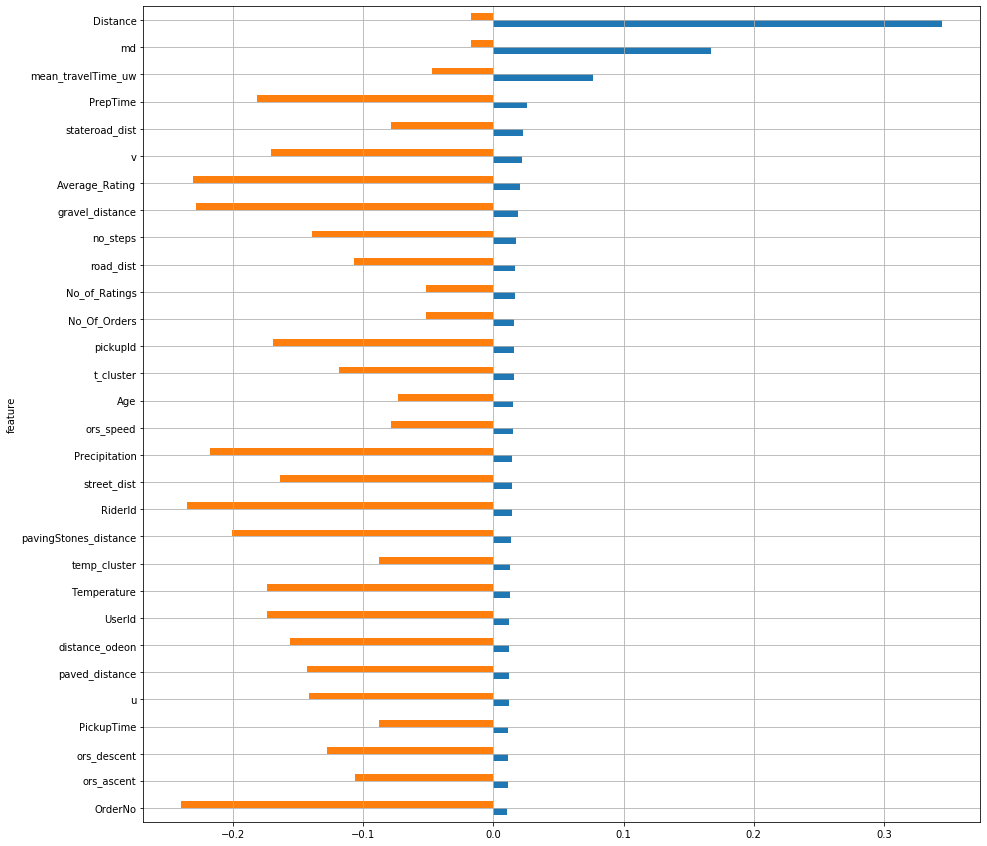

In [14]:
# Merged
m = pd.merge(imp, corr_df, left_index=True, right_index=True).sort_values('importance')
m['correlation'] = m.cor.round(2)
m['oneMinusCor'] = -(1 - m.cor)/4
m[['importance', 'correlation', 'feat2']]
m.plot(kind='barh', y=['importance', 'oneMinusCor'], secondary_y=False, legend=False, grid=True, figsize=[15, 15])

In [ ]:
#imp.loc[['v', 'px', 'u', 'py', 'vt', 'pxt', 'ut', 'pyt', 'md', 'mdt']].sort_values('importance', ascending=False)

hyperparamter tuning

In [ ]:
param_grid = {
    'estimator__subsample': [0.8, 0.9],
}
grid = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
print ('Best RMSE %.8f' % sqrt(-1 * grid.best_score_))
print ('Best paramter combination', grid.best_params_)

Best RMSE 633.81396762
Best paramter combination {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1.0, 'n_estimators': 200, 'subsample': 0.8}

---
Best RMSE 633.81396762
Best paramter combination {'max_depth': 4, 'n_estimators': 200, 'subsample': 0.8}

feature elimination

In [ ]:
no_features = feat_mat.shape[1]
feat_to_remove = 2
print((no_features, feat_to_remove))

model = pipe.named_steps.estimator

no_features = feat_mat.shape[1]
feat_to_remove = 2
print((no_features, feat_to_remove))

ref_params = {
    'min_features_to_select': no_features - feat_to_remove,
    'cv': 5, 
    #'scoring': 'neg_mean_squared_error',
    'verbose': 2,
    'n_jobs': -1, 
}
rfe = RFECV(model, **ref_params)
rfe = rfe.fit(feat_mat, y_train)

print('RFE support:')
rfe.support_

print('RFE ranking:')
rfe.ranking_

plotting av cluster på kart:

In [ ]:
#fig = plt.figure(figsize = [12, 8])
#plt.scatter(x='PickupLong', y='PickupLat', alpha=1, c='p_cluster', data=train.sample(5000), norm=plt.Normalize(vmin=0, vmax=p_clusterer.labels_.max()) ,cmap=plt.cm.Spectral)
#mplleaflet.display()

other things:

In [ ]:
#from sklearn.inspection import partial_dependence
#partial_dependence(model, X_train, [0])

In [ ]:
#condition numbers
#https://towardsdatascience.com/feature-selection-why-how-explained-part-1-c2f638d24cdb

submiting:

In [100]:
feat_mat.columns.values
X_train.columns.values.tolist() == X_test.columns.values.tolist()

array(['Age', 'Average_Rating', 'Distance', 'No_Of_Orders',
       'No_of_Ratings', 'OrderNo', 'PickupTime', 'Precipitation',
       'PrepTime', 'RiderId', 'Temperature', 'UserId', 'distance_odeon',
       'gravel_distance', 'md', 'mean_travelTime_uw', 'no_steps',
       'ors_ascent', 'ors_descent', 'ors_speed', 'paved_distance',
       'pavingStones_distance', 'pickupId', 'road_dist', 'stateroad_dist',
       'street_dist', 'u', 'v', 't_cluster', 'temp_cluster'], dtype=object)

True

In [15]:
orderNo = 'Order_No_' + X_test.OrderNo.astype(str)
y_test = pipe.predict(X_test)
time_from_pickup_to_arrival = y_test.round(0).astype(int)
submit = pd.DataFrame(zip(orderNo, time_from_pickup_to_arrival), columns=['Order_No', 'Time from Pickup to Arrival'])
submit
now = datetime.now().strftime('_%m%d%H%M')
submit.to_csv(path_or_buf=f'submission{now}.csv', index=False)
print(f'File submission{now}.csv saved.')

,Order_No,Time from Pickup to Arrival
0,Order_No_19248,1442
1,Order_No_19248,1470
2,Order_No_12736,1251
3,Order_No_768,1608
4,Order_No_768,1608
...,...,...
55674,Order_No_1969,1667
55675,Order_No_10591,2516
55676,Order_No_1603,1868
55677,Order_No_1603,1868


File submission_11250919.csv saved.
